Directory ./dataset already exists, skipping unzip.
Directory dataset_split already exists, skipping dataset split.
Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
Train samples: 1260
Test samples: 540


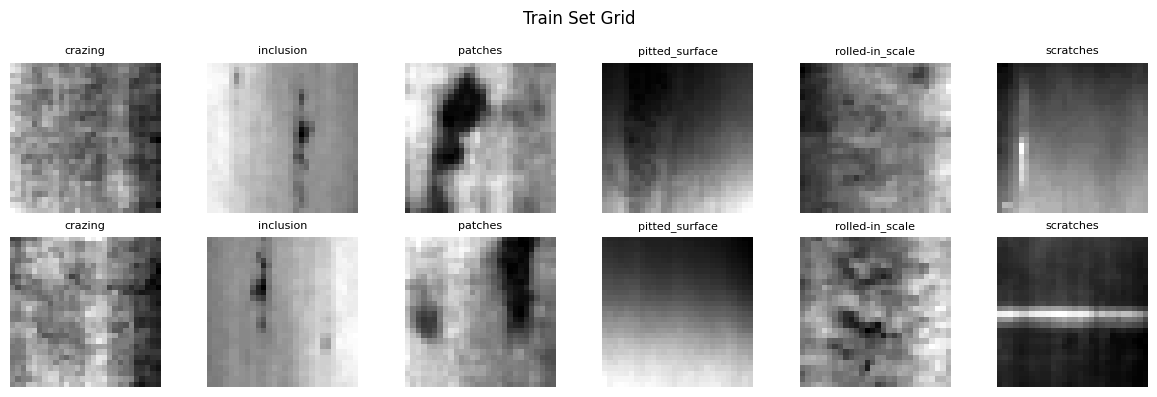

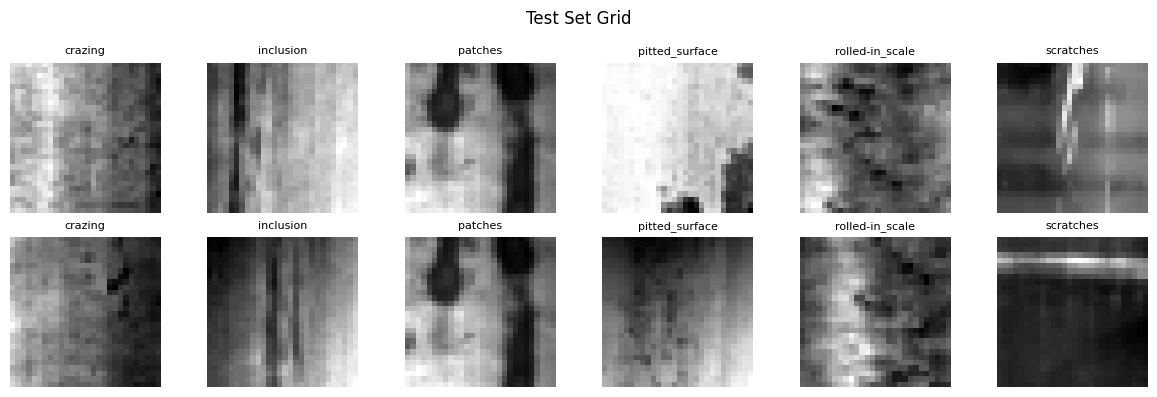

ViT(
  (to_patch_embedding): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=128, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=128, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=128, out_features=256, bias=True)
              (1): GELU(approximate='none')
              (2):

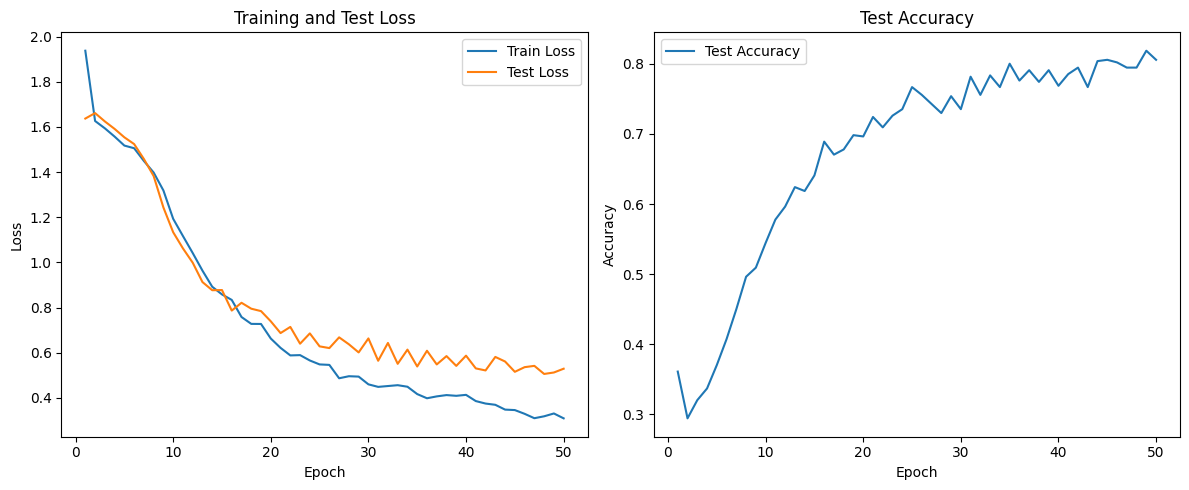

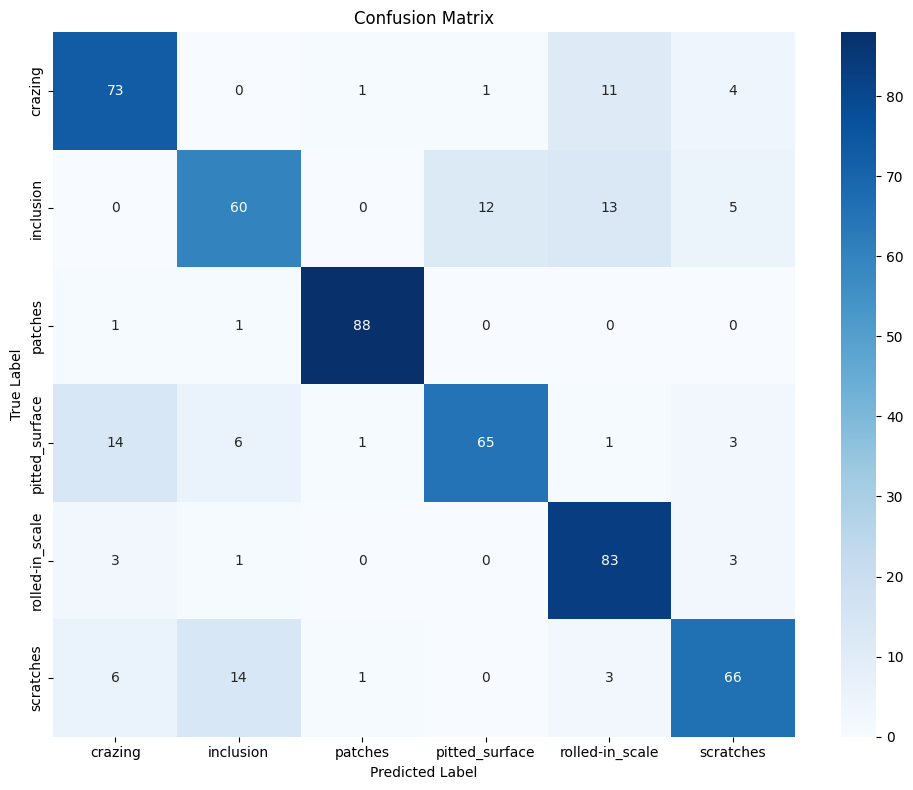

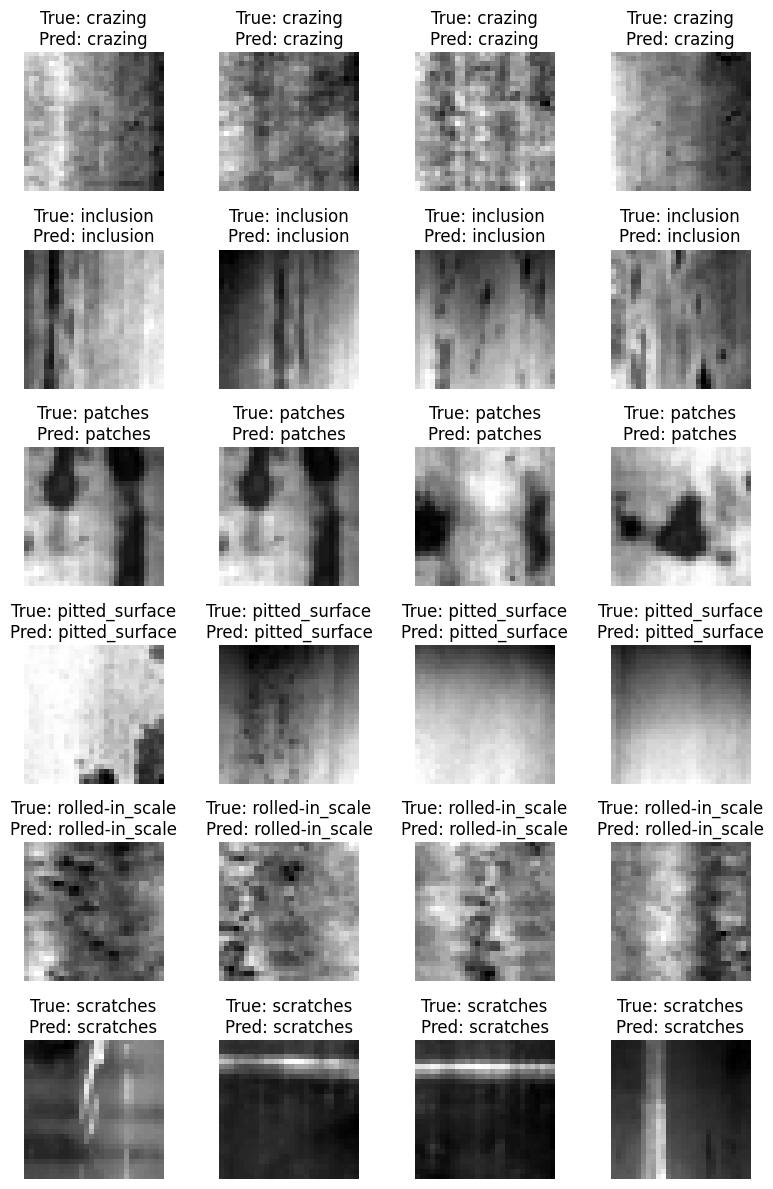

  Test Loss: 0.5290, Accuracy: 0.8056 (435/540)
Final Test Accuracy: 0.8056


In [1]:
import zipfile
import os
import shutil
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from einops import rearrange, repeat

# ============================
# Step 1: Unzip Dataset
# ============================
zip_path = 'dataset.zip'  # <-- replace with the exact uploaded filename
extract_path = './dataset'  # folder where you want to extract

# Unzip the dataset
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"✅ Unzipped to: {os.path.abspath(extract_path)}")
    
    # Optional: List the extracted folder contents
    print("Contents:")
    print(os.listdir(extract_path))
else:
    print(f"Directory {extract_path} already exists, skipping unzip.")

# ============================
# Step 2: Split Dataset into Train/Test
# ============================
# Set source folder and target folder
SOURCE_DIR = 'dataset'  # folder from unzip
TARGET_DIR = 'dataset_split'  # new folder to store split data

# Create target directory if it doesn't exist
if not os.path.exists(TARGET_DIR):
    # Split ratios
    train_ratio = 0.7
    test_ratio = 0.3
    
    # Set random seed for reproducibility
    random.seed(42)
    
    # Create target train/test directories per class
    for split in ['train', 'test']:
        for class_name in os.listdir(SOURCE_DIR):
            class_path = os.path.join(SOURCE_DIR, class_name)
            if os.path.isdir(class_path):
                os.makedirs(os.path.join(TARGET_DIR, split, class_name), exist_ok=True)
    
    # Process each class folder
    for class_name in os.listdir(SOURCE_DIR):
        class_path = os.path.join(SOURCE_DIR, class_name)
        if not os.path.isdir(class_path):
            continue
        
        images = os.listdir(class_path)
        random.shuffle(images)
        
        # Calculate split point
        train_cutoff = int(len(images) * train_ratio)
        
        # Split images
        train_images = images[:train_cutoff]
        test_images = images[train_cutoff:]
        
        # Copy training images
        for img_name in train_images:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(TARGET_DIR, 'train', class_name, img_name)
            shutil.copyfile(src, dst)
        
        # Copy testing images
        for img_name in test_images:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(TARGET_DIR, 'test', class_name, img_name)
            shutil.copyfile(src, dst)
    
    print("✅ Dataset split complete!")
else:
    print(f"Directory {TARGET_DIR} already exists, skipping dataset split.")

# Set dataset paths
TRAIN_PATH = 'dataset_split/train'
TEST_PATH = 'dataset_split/test'

# Define image transforms: resize, grayscale, tensor, normalize
transform_custom = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_set = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=transform_custom)
test_set = torchvision.datasets.ImageFolder(root=TEST_PATH, transform=transform_custom)

# Print dataset info
print("Classes:", train_set.classes)
print("Train samples:", len(train_set))
print("Test samples:", len(test_set))

# Create data loaders
BATCH_SIZE = 512
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Show example images (2 per class)
def show_2x6_grid(dataset, n_per_class=2, title="Example Grid"):
    class_counts = {i: 0 for i in range(len(dataset.classes))}
    collected = {i: [] for i in range(len(dataset.classes))}
    
    for img, label in dataset:
        if class_counts[label] < n_per_class:
            collected[label].append(img)
            class_counts[label] += 1
        
        if all(c >= n_per_class for c in class_counts.values()):
            break
    
    fig, axes = plt.subplots(n_per_class, len(dataset.classes), figsize=(len(dataset.classes)*2, n_per_class*2))
    for col, imgs in collected.items():
        for row in range(n_per_class):
            ax = axes[row][col] if n_per_class > 1 else axes[col]
            img = imgs[row].numpy().transpose(1, 2, 0) * 0.5 + 0.5  # unnormalize
            ax.imshow(img.squeeze(), cmap='gray')
            ax.set_title(dataset.classes[col], fontsize=8)
            ax.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Show training and test grids
show_2x6_grid(train_set, 2, "Train Set Grid")
show_2x6_grid(test_set, 2, "Test Set Grid")

# Helper function for the ViT model
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# === TODO 1: Define PreNorm block ===
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
        
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

# === TODO 2: Define FeedForward block ===
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.net(x)

# === TODO 3: Define Attention block ===
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        # Get query, key, value projections
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        # Compute scaled dot-product attention
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        
        # Apply softmax and dropout
        attn = self.attend(dots)
        attn = self.dropout(attn)
        
        # Apply attention to values
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        
        # Project to output dimension
        return self.to_out(out)

# === TODO 4: Define Transformer Encoder ===
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))
    
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

# === TODO 5: Define Vision Transformer (ViT) ===
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads,
                mlp_dim, pool='cls', channels=1, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        # Image parameters
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        # Make sure image dimensions are divisible by patch dimensions
        assert image_height % patch_height == 0 and image_width % patch_width == 0, \
               'Image dimensions must be divisible by patch dimensions'
        
        # Calculate number of patches
        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        
        # Define pooling strategy
        assert pool in {'cls', 'mean'}, 'Pool type must be either cls (cls token) or mean (mean pooling)'
        
        # Patch embedding
        self.to_patch_embedding = nn.Sequential(
            # Rearrange input image into patches and flatten each patch into a vector
            nn.Conv2d(channels, dim, kernel_size=(patch_height, patch_width), stride=(patch_height, patch_width)),
        )
        
        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        
        # Position embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        
        # Dropout
        self.dropout = nn.Dropout(emb_dropout)
        
        # Transformer
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        
        # Pooling and classification
        self.pool = pool
        self.to_latent = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        # Extract patches and embed
        x = self.to_patch_embedding(img)  # Shape: [batch, dim, grid_h, grid_w]
        x = x.flatten(2).transpose(1, 2)  # Shape: [batch, num_patches, dim]
        
        # Add CLS token
        b, n, _ = x.shape
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add position embedding
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        
        # Apply transformer
        x = self.transformer(x)
        
        # Pool based on strategy
        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]
        
        # Apply MLP head
        x = self.to_latent(x)
        return self.mlp_head(x)

# Initialize ViT model
model = ViT(
    image_size=28,
    patch_size=4,
    num_classes=len(train_set.classes),
    channels=1,
    dim=128,           # Increased embedding dimension
    depth=6,           # Depth of transformer
    heads=8,           # Number of attention heads
    mlp_dim=256,       # Dimension of feed-forward layer
    dropout=0.1,       # Dropout rate
    emb_dropout=0.1    # Embedding dropout rate
)

# Print model summary
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # 0.0005
criterion = nn.CrossEntropyLoss()

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
model = model.to(device)

# Training function
def train_epoch(model, optimizer, data_loader, loss_history):
    model.train()
    total_samples = len(data_loader.dataset)
    total_loss = 0
    
    for i, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Compute loss
        loss = criterion(output, target)
        total_loss += loss.item() * data.size(0)
        
        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print(f'  Batch {i}/{len(data_loader)}, Loss: {loss.item():.4f}')
    
    # Compute average loss
    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print(f'  Training Loss: {avg_loss:.4f}')
    
    return avg_loss

# Evaluation function
def evaluate(model, data_loader, loss_history):
    model.eval()
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Compute loss
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)
            
            # Get predictions and count correct samples
            _, pred = torch.max(output, 1)
            correct_samples += pred.eq(target).sum().item()
    
    # Compute average loss and accuracy
    avg_loss = total_loss / total_samples
    accuracy = correct_samples / total_samples
    
    loss_history.append(avg_loss)
    print(f'  Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f} ({correct_samples}/{total_samples})')
    
    return avg_loss, accuracy

# Function to plot confusion matrix
def plot_confusion_matrix(model, data_loader, class_names):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Get predictions
            _, pred = torch.max(output, 1)
            
            # Collect predictions and targets
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return cm

# Function to plot example predictions
def plot_classwise_predictions(model, data_loader, class_names, samples_per_class=4):
    model.eval()
    class_samples = {i: {'correct': [], 'incorrect': []} for i in range(len(class_names))}
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Get predictions
            _, pred = torch.max(output, 1)
            
            # Store samples
            for i in range(len(target)):
                label = target[i].item()
                is_correct = pred[i].item() == label
                
                # Make sure we don't have too many samples for this class
                if len(class_samples[label]['correct' if is_correct else 'incorrect']) < samples_per_class:
                    sample = {'image': data[i].cpu(), 'pred': pred[i].item()}
                    class_samples[label]['correct' if is_correct else 'incorrect'].append(sample)
            
            # Check if we have enough samples
            done = True
            for class_idx in range(len(class_names)):
                if len(class_samples[class_idx]['correct']) < samples_per_class:
                    done = False
                    break
            
            if done:
                break
    
    # Plot examples
    fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(samples_per_class*2, len(class_names)*2))
    
    for i, class_idx in enumerate(range(len(class_names))):
        samples = class_samples[class_idx]['correct'][:samples_per_class]
        
        for j, sample in enumerate(samples):
            ax = axes[i, j]
            img = sample['image'].numpy().transpose(1, 2, 0) * 0.5 + 0.5  # unnormalize
            ax.imshow(img.squeeze(), cmap='gray')
            ax.set_title(f"True: {class_names[class_idx]}\nPred: {class_names[sample['pred']]}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return class_samples

# Set number of epochs
N_EPOCHS = 50

# Initialize loss trackers
train_loss_history, test_loss_history = [], []
test_accuracy_history = []

# Main training loop
start_time = time.time()

for epoch in range(1, N_EPOCHS + 1):
    print(f'Epoch: {epoch}/{N_EPOCHS}')
    
    # Train
    train_loss = train_epoch(model, optimizer, train_loader, train_loss_history)
    
    # Evaluate
    test_loss, test_accuracy = evaluate(model, test_loader, test_loss_history)
    test_accuracy_history.append(test_accuracy)

# Print total time
total_time = time.time() - start_time
print(f'Execution time: {total_time:.2f} seconds')

# Save trained model
torch.save(model.state_dict(), '112101014.pth')  # Replace with your actual Student ID
print("✅ Model saved as .pth")

# Plot training progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, N_EPOCHS + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, N_EPOCHS + 1), test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, N_EPOCHS + 1), test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrix
cm = plot_confusion_matrix(model, test_loader, train_set.classes)

# Plot example predictions
samples = plot_classwise_predictions(model, test_loader, train_set.classes, samples_per_class=4)

# Final evaluation
final_loss, final_accuracy = evaluate(model, test_loader, [])
print(f"Final Test Accuracy: {final_accuracy:.4f}")